# DQN with TensorFlow & gym
<br>
In this notebook we'll build our very first Deep Q-Network with TensorFlow deep learning framework and OpenAI gym <a href='https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py'>MountainCar-v0</a> environment. <br><br><br>


In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [2]:
tf.reset_default_graph()

In [3]:
class DQN:
    def __init__(self, input_shape:object = None, action_size:object = None, scope:object = None) -> object:

        if input_shape is None:
            input_shape = [None, 4]
        self.max_size = 1000000
        self.mem = []

        with tf.variable_scope(scope):
            self.scope = scope
            self.input_shape = input_shape
            self.action_size = action_size
            self.initializer = tf.contrib.layers.variance_scaling_initializer()

            self.states = tf.placeholder(shape=input_shape, dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(
                self.actions, action_size, dtype=tf.float32)

            fc1 = fully_connected(self.states, 
                                  512, 
                                  activation_fn=tf.nn.relu,
                                  weights_initializer=self.initializer)
            fc2 = fully_connected(fc1, 
                                  256, 
                                  activation_fn=tf.nn.relu,
                                  weights_initializer=self.initializer)
            fc3 = fully_connected(fc2, 
                                  256, 
                                  activation_fn=tf.nn.relu,
                                  weights_initializer=self.initializer)
            self.q = fully_connected(fc3, 
                                    action_size, 
                                    activation_fn=None,
                                    weights_initializer=self.initializer)
            

            self.target_q = tf.placeholder(shape=[None], dtype=tf.float32)
            self.responsible_output = tf.reduce_sum(tf.multiply(
                self.q, self.actions_onehot), axis=1, keep_dims=False)
            self.loss = tf.reduce_mean(
                tf.square(self.responsible_output - self.target_q))

            self.update_model = tf.train.AdamOptimizer().minimize(self.loss)

    def action(self, sess, state):
        q = sess.run(self.q, feed_dict={self.states: state[np.newaxis, ...]})
        return np.argmax(q)

    def train(self, sess, batch, learning_rate, tnet):
        assert len(batch) > 0
        states = np.vstack(batch[:, 0])
        actions = np.array(batch[:, 1])
        rewards = batch[:, 2]
        next_states = np.vstack(batch[:, 3])
        dones = batch[:, 4]

        next_q = sess.run(tnet.q, feed_dict={tnet.states: next_states})

        next_q = rewards + (1. - dones.astype(np.float32)) * \
            learning_rate * np.amax(next_q, axis=1, keepdims=False)

        sess.run(self.update_model, feed_dict={self.states: states,
                                               self.actions: actions,
                                               self.target_q: next_q})

    def add(self, element):
        self.mem.append(element)

        if len(self.mem) > self.max_size:
            self.mem.pop(0)

    def sample(self, size):
        size = min(size, len(self.mem))
        return random.sample(self.mem, size)


    def update_graph(self, from_graph:object, to_graph:object) -> object:
        from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_graph)
        to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_graph)
    
        holder = []
        for from_var, to_var in zip(from_vars, to_vars):
            holder.append(to_var.assign(from_var))
        return holder

In [4]:
target_update = 200
epsilon_max = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
learning_rate = 0.99
batch_size = 64
EPISODES = 300



env = gym.make('MountainCar-v0')
action_size = env.action_space.n
input_shape = [None] + list(env.observation_space.shape)

time_step = 0.0
epsilon = epsilon_max

Q_Network = DQN(input_shape=input_shape,
                action_size=action_size, scope='Q_Network')
Train_Network = DQN(input_shape=input_shape,
                    action_size=action_size, scope='Train_Network')

update_ops = Q_Network.update_graph('Q_Network', 'Train_Network')

saver = tf.train.Saver()
score = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(EPISODES):
        total_reward = 0
        state = env.reset()
        while True:
            env.render()
            if np.random.rand() < epsilon:
                action = np.random.randint(action_size)
            else:
                action = Q_Network.action(sess, state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            Q_Network.add([state, action, reward, next_state, done])

            time_step += 1.
            epsilon = epsilon_min + \
                (epsilon_max - epsilon_min) * \
                np.exp(-epsilon_decay * time_step)

            batch = np.array(Q_Network.sample(batch_size))
            Q_Network.train(sess, batch, learning_rate, Train_Network)

            state = np.copy(next_state)

            if int(time_step) % target_update == 0:
                sess.run(update_ops)
                saver.save(sess, "./checkpoints/MountainCar_DQN.ckpt")

            if done:
                print('Epoch:', epoch, 'Total Rewards:', total_reward)
                score.append(total_reward)
                break
                
    

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch: 0 Total Rewards: -200.0
Epoch: 1 Total Rewards: -200.0
Epoch: 2 Total Rewards: -200.0
Epoch: 3 Total Rewards: -200.0
Epoch: 4 Total Rewards: -200.0
Epoch: 5 Total Rewards: -200.0
Epoch: 6 Total Rewards: -200.0
Epoch: 7 Total Rewards: -200.0
Epoch: 8 Total Rewards: -200.0
Epoch: 9 Total Rewards: -200.0
Epoch: 10 Total Rewards: -200.0
Epoch: 11 Total Rewards: -200.0
Epoch: 12 Total Rewards: -200.0
Epoch: 13 Total Rewards: -200.0
Epoch: 14 Total Rewards: -200.0
Epoch: 15 Total Rewards: -200.0
Epoch: 16 Total Rewards: -200.0
Epoch: 17 Total Rewards: -200.0
Epoch: 18 Total Rewards: -200.0
Epoch: 19 Total Rewards: -200.0
Epoch: 20 Total Rewards: -170.0
Epoch: 21 Total Rewards: -200.0
Epoch: 22 Total Rewards: -200.0
Epoch: 23 Total Rewards: -169.0
Epoch: 24 Total Rewards: -200.0
Epoch: 25 Total Rewards: -200.0
Epoch:

Epoch: 242 Total Rewards: -144.0
Epoch: 243 Total Rewards: -89.0
Epoch: 244 Total Rewards: -119.0
Epoch: 245 Total Rewards: -106.0
Epoch: 246 Total Rewards: -138.0
Epoch: 247 Total Rewards: -156.0
Epoch: 248 Total Rewards: -164.0
Epoch: 249 Total Rewards: -90.0
Epoch: 250 Total Rewards: -85.0
Epoch: 251 Total Rewards: -188.0
Epoch: 252 Total Rewards: -86.0
Epoch: 253 Total Rewards: -164.0
Epoch: 254 Total Rewards: -89.0
Epoch: 255 Total Rewards: -97.0
Epoch: 256 Total Rewards: -88.0
Epoch: 257 Total Rewards: -141.0
Epoch: 258 Total Rewards: -85.0
Epoch: 259 Total Rewards: -167.0
Epoch: 260 Total Rewards: -150.0
Epoch: 261 Total Rewards: -160.0
Epoch: 262 Total Rewards: -123.0
Epoch: 263 Total Rewards: -87.0
Epoch: 264 Total Rewards: -172.0
Epoch: 265 Total Rewards: -97.0
Epoch: 266 Total Rewards: -175.0
Epoch: 267 Total Rewards: -169.0
Epoch: 268 Total Rewards: -142.0
Epoch: 269 Total Rewards: -176.0
Epoch: 270 Total Rewards: -131.0
Epoch: 271 Total Rewards: -88.0
Epoch: 272 Total Rewa

In [5]:
score = np.array(score)
totla_epoch = len(score)

print("Total Epoch:", totla_epoch)
print("Min Reward:", score.min())
print("Max Reward:", score.max())
print("Average Reward:", score.mean())
print("Highest Performance:", score.max(), "Reached at:", np.argmax(score) + 1, "Episode")

Total Epoch: 300
Min Reward: -200.0
Max Reward: -85.0
Average Reward: -142.53333333333333
Highest Performance: -85.0 Reached at: 130 Episode


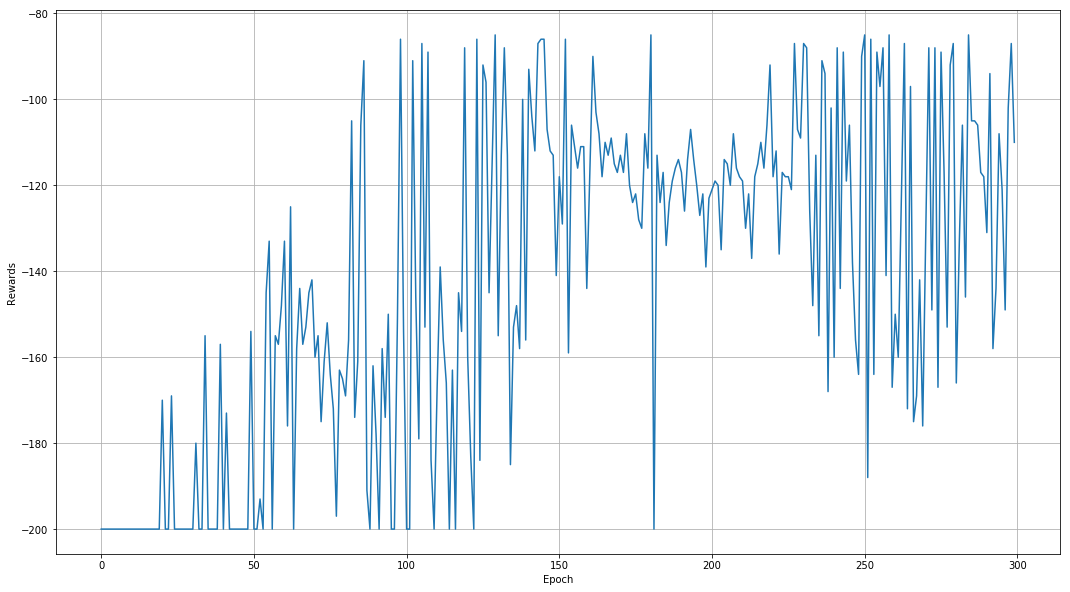

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(18,10))
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.plot(range(totla_epoch), score)
plt.show()